# S&P500 L/S 11-month rolling momentum strategy
Code taken from https://www.youtube.com/watch?v=5W_Lpz1ZuTI
This strategy aims to construct a long short portfolio of the top 10% and bottom 10% of performers each month in the SP500 based on rolling 11 month performance. Will long the winners and short the losers, and profit from the spread. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#import yfinance as yf
#import csv

#### Read data from yfinance locally, sort 

In [2]:
df2= pd.read_pickle("SP500_11yr.pkl")
#filter for prices
prices =df2['Adj Close']

#convert index from string into datetime
prices.index= pd.to_datetime(prices.index)


Find monthly returns, and cumulate them on an 11 year rolling basis for all SP500 stocks

In [3]:
#find daily returns and cumulate them on a monthly basis- that's what the resample function does
mtl_ret = prices.pct_change().resample('M').agg(lambda x: (x+1).prod() -1)

#we want to calculate the past 11 month returns, rolled for each month. the first 10 entries will be NaN
past_11 = (mtl_ret+1).rolling(11).apply(np.prod)-1

Calculate SPY monthly returns over same period

In [4]:
#spy prices and monthly returns

SPY= pd.read_pickle('SPY_11yr.pkl')
SPY = SPY['Adj Close']
SPY_mtl = SPY.pct_change().resample('M').agg(lambda x: (x+1).prod() -1)

#### Create function for momentum strategy, taking a date as an input

In [26]:
def momentum(formation):
    end_measurement = formation - MonthEnd(1)
    ret_12 = past_11.loc[end_measurement]
    ret_12 = ret_12.reset_index()
    ret_12['decile']= pd.qcut(ret_12.iloc[:,1],10, labels=False,duplicates='drop')
    winners = ret_12[ret_12.decile ==9]
    losers= ret_12[ret_12.decile <8]
    winnerret= mtl_ret.loc[formation +MonthEnd(1), mtl_ret.columns.isin(winners['index'])]
    loserret =  mtl_ret.loc[formation +MonthEnd(1), mtl_ret.columns.isin(losers['index'])]
    SPYret= SPY_mtl.loc[formation + MonthEnd(1)]
    Momentumprofit =    winnerret.mean() -loserret.mean()
    return Momentumprofit

#### Define backtest, output is 2 dataframes, one is returns, other is indexed returns. Both vs market

In [27]:
def momentum_backtest(formation):
    #Backtest
    end_date = dt.datetime(2020,12,30) #last date in the dataset we have
    start_date = formation
    num_months = (end_date.year - start_date.year) * 12 + (end_date. month - start_date. month)
    profits = []
    dates= []
    for i in range(num_months):
        profits.append(momentum(formation + MonthEnd(i)))
        dates.append(formation + MonthEnd(i))
    
    
    #creating a dataframe with monthly returns of each strategy
    frame= pd.DataFrame(profits)
    
    #end_date1 = dt.datetime(2020,12,30)
    a= formation.date()
    b= end_date.date()
    SPY_cut = SPY_mtl.loc(axis=0)[a:b]
    frame['SP500']= SPY_cut.values
    
    frame['Date']= pd.DataFrame(dates)
    frame = frame.set_index('Date')
    frame.columns =['Momentum', 'SP500']
    #excess return column
    frame['Excess']= frame.iloc[:,0] - frame.iloc[:,1]
    #when do we have outperformance?
    frame['Outperformed'] =['Yes' if i>0 else 'No' for i in frame.Excess]
    
    # creating a df with indexed returns
    # make lists of returns
    indexed_profits = [100]
    indexed_spy= [100]
    x = 100
    y = 100
    for i in frame.Momentum:
        x= x*(1+ i)
        indexed_profits.append(x)
    for i in frame.SP500:
        y= y*(1+i)
        indexed_spy.append(y)
    #combine lists into df
    indexed_frame= pd.DataFrame(indexed_profits)
    indexed_frame['SP500']= pd.DataFrame(indexed_spy)
    indexed_frame['Date']= pd.DataFrame(dates)
    indexed_frame = indexed_frame.set_index('Date')
    indexed_frame.columns =['Momentum', 'SP500']

    return frame, indexed_frame

Run Backtest

<AxesSubplot:xlabel='Date'>

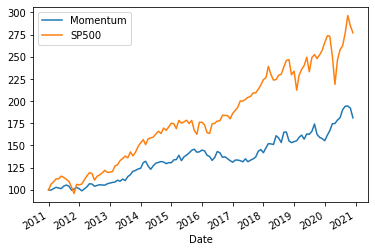

In [28]:
formation = dt.datetime(2010,12,31)

frame, indexed_frame = momentum_backtest(formation)

indexed_frame.plot()

In [8]:
x =frame[frame.Outperformed =="Yes"].shape
y =frame.shape

x[0]/y[0]


0.5166666666666667

Performance analysis:

Maximum daily drawdowns are important- but currently only have monthly returns. 
Plot a histogram of monthly returns
How many times was there a 5%+ daily drawdown?

Visibility into the portfolio- which stocks were held onto the longest? Find a way to log trades

Calculate betas properly- need historical risk free rates, and need market risk premium- although could just use SPY returns
- What period look back should betas be calculated on? 1 month? 3 month rolling? An average across whole period and then min/max?




In [30]:
corr1= frame['Momentum'].corr(frame['SP500'])
corr2= indexed_frame['Momentum'].corr(indexed_frame['SP500'])

#corr on monthly returns is lower than indexed returns. which one should i use?
print(corr1)
print(corr2)

0.1940313281589688
0.9545913836522045


In [37]:
std1= frame['Momentum'].std()
ret1= (indexed_frame['Momentum'].iloc[-1] - indexed_frame['Momentum'].iloc[0])/ indexed_frame['Momentum'].iloc[0]
sharpe = (((ret1 +1)**(1/11)) -0.02)/std1
sharpe

40.897963696145055

In [35]:
frame['Momentum'].min()



-0.06691560383095296

In [11]:
#calculating betas
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  # To visualize

#need to find a risk free rate to use, as well as 

In [38]:
X = indexed_frame.iloc[:, 1].values.reshape(-1, 1)  # spy is x axis values converts it into a numpy array
Y = indexed_frame.iloc[:, 0].values.reshape(-1, 1)  # momentum is y axis -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [22]:
indexed_frame.iloc[:, 1]

Date
2010-12-31    100.000000
2011-01-31    106.530004
2011-02-28    108.942437
2011-03-31    112.423863
2011-04-30    112.306120
                 ...    
2020-08-31    277.084408
2020-09-30    296.498235
2020-10-31    284.867211
2020-11-30    276.986136
NaT           306.774786
Name: SP500, Length: 121, dtype: float64

In [39]:
print(linear_regressor.coef_)
print(linear_regressor.intercept_)

[[0.4408508]]
[55.78100437]


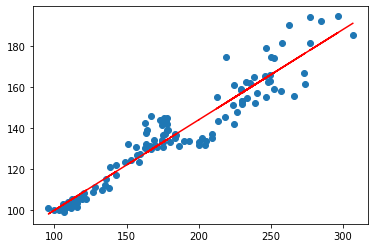

In [40]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

(array([1., 0., 1., 1., 0., 0., 0., 0., 3., 0., 1., 1., 2., 2., 0., 5., 1.,
        1., 9., 3., 4., 3., 8., 3., 6., 5., 7., 4., 7., 5., 7., 6., 4., 1.,
        3., 3., 2., 3., 0., 0., 4., 2., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-0.0669156 , -0.06407332, -0.06123103, -0.05838874, -0.05554646,
        -0.05270417, -0.04986188, -0.04701959, -0.04417731, -0.04133502,
        -0.03849273, -0.03565044, -0.03280816, -0.02996587, -0.02712358,
        -0.0242813 , -0.02143901, -0.01859672, -0.01575443, -0.01291215,
        -0.01006986, -0.00722757, -0.00438529, -0.001543  ,  0.00129929,
         0.00414158,  0.00698386,  0.00982615,  0.01266844,  0.01551072,
         0.01835301,  0.0211953 ,  0.02403759,  0.02687987,  0.02972216,
         0.03256445,  0.03540674,  0.03824902,  0.04109131,  0.0439336 ,
         0.04677588,  0.04961817,  0.05246046,  0.05530275,  0.05814503,
         0.06098732,  0.06382961,  0.06667189,  0.06951418,  0.07235647,
         0.07519876]),
 <BarContainer object

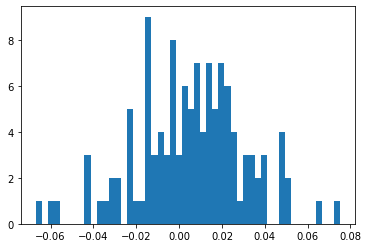

In [45]:

plt.hist(frame['Momentum'], bins=50)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  2.,
         1.,  1.,  0.,  0.,  3.,  2.,  3.,  4.,  7.,  1.,  3.,  8.,  7.,
         8.,  5., 14.,  8.,  7.,  7.,  5.,  4.,  2.,  3.,  0.,  2.,  2.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([-0.12511928, -0.12008002, -0.11504075, -0.11000148, -0.10496222,
        -0.09992295, -0.09488368, -0.08984442, -0.08480515, -0.07976588,
        -0.07472662, -0.06968735, -0.06464809, -0.05960882, -0.05456955,
        -0.04953029, -0.04449102, -0.03945175, -0.03441249, -0.02937322,
        -0.02433395, -0.01929469, -0.01425542, -0.00921615, -0.00417689,
         0.00086238,  0.00590164,  0.01094091,  0.01598018,  0.02101944,
         0.02605871,  0.03109798,  0.03613724,  0.04117651,  0.04621578,
         0.05125504,  0.05629431,  0.06133357,  0.06637284,  0.07141211,
         0.07645137,  0.08149064,  0.08652991,  0.09156917,  0.09660844,
         0.10164771,  0.10668697,  0.11172624,  0.11676551,

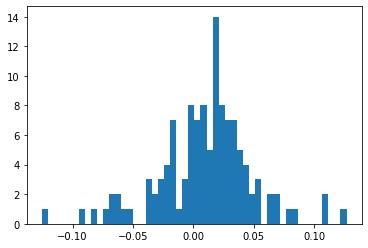

In [48]:
plt.hist(frame['SP500'], bins=50)

In [52]:
end_measurement = formation - MonthEnd(1)
ret_12 = past_11.loc[end_measurement]
ret_12 = ret_12.reset_index()
ret_12['decile']= pd.qcut(ret_12.iloc[:,1],10, labels=False,duplicates='drop')
winners = ret_12[ret_12.decile ==9]
losers= ret_12[ret_12.decile <8]
winnerret= mtl_ret.loc[formation +MonthEnd(1), mtl_ret.columns.isin(winners['index'])]
loserret =  mtl_ret.loc[formation +MonthEnd(1), mtl_ret.columns.isin(losers['index'])]
SPYret= SPY_mtl.loc[formation + MonthEnd(1)]
Momentumprofit =    winnerret.mean() -loserret.mean()



,index,2010-11-30 00:00:00,decile
0,A,0.127132,5
4,ABBV,0.000000,2
5,ABC,0.197040,6
6,ABMD,0.315006,7
7,ABT,-0.109494,0
...,...,...,...
498,XRAY,-0.116761,0
499,XYL,0.000000,2
501,ZBH,-0.166639,0
502,ZBRA,0.285361,7
